In [1]:
#For working in Colab:

# !pip install cfbd      
# # !pip install requests

In [2]:
# import requests

# url = 'https://raw.githubusercontent.com/dyeds/PIC-16B-Project/main/DataFunctions.py'
# r=requests.get(url)

# with open('DataFunctions.py', 'w') as f:  Using 'r' instead of 'w' gives error file does not exist so left as is
#     f.write(r.text)

In [3]:
import cfbd
from cfbd.rest import ApiException
from pprint import pprint
import pandas as pd
import sqlite3
import DataFunctions
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '3WCU5V2X05Rvh60ZxUG8FarJN4s2D1lcd2c2r6Kz/qL1Y3tVBJtWsuNATnzHRV2h'
configuration.api_key_prefix['Authorization'] = 'Bearer'

## Data Preprocessing

Games DF

In [4]:
api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
year=2022
division="fbs"

# no longer need, right?
# try:
#     api_response = api_instance.get_games(year=year,division=division)
#     print(len(api_response))
# except:
#     print(ApiException)
    

In [5]:
gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=2022)
# len(gamelist)

In [6]:
games_df = DataFunctions.df_from_games(gamelist=gamelist)
# games_df.head()

In [7]:
# conn = sqlite3.connect("CollegeFootball.db")
# games_df.to_sql("games",conn,if_exists="replace",index=False)
# conn.close()


In [8]:
# we can see with this code that we can extract DF from SQL db

# conn = sqlite3.connect("CollegeFootball.db")
# trialdf = pd.read_sql_query("SELECT * FROM games",conn)
# conn.close()
# print(trialdf.shape)
# trialdf.head()


Betting lines DF

In [9]:
api_instance1 = cfbd.BettingApi(cfbd.ApiClient(configuration))

In [10]:
conferences=[]
for game in gamelist:
    conferences.append(game.away_conference)
conferences=set(conferences)

conferences

{'ACC',
 'American Athletic',
 'Big 12',
 'Big Ten',
 'Conference USA',
 'FBS Independents',
 'Mid-American',
 'Mountain West',
 'Pac-12',
 'SEC',
 'Sun Belt'}

In [11]:
betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=2022,conferences=conferences)

In [12]:
betting_df=DataFunctions.df_betting_lines(betting_list)
betting_df

#warning seems to be since betting line -0.0 for one of the games but still stores value as 0 so should be fine

,id,av_spread,av_total
0,401411101,-24.375,51.375
1,401404079,7.125,65.625
2,401403893,1.500,51.000
3,401404080,2.500,45.000
4,401404081,13.625,53.000
...,...,...,...
733,401416641,-2.750,55.750
734,401404036,11.500,47.000
735,401404037,12.000,73.750
736,401411151,-12.000,47.250


In [13]:
# conn=sqlite3.connect("CollegeFootball.db")
# betting_df.to_sql("betting_lines",conn,if_exists="replace",index=False)
# conn.close()

In [14]:
# #sample merge dataframe

# cmd=\
# """
# SELECT G.away_team,G.away_points,G.home_points,G.home_team,B.av_spread,B.av_total
# FROM games G
# INNER JOIN betting_lines B ON G.id=B.id
# """
# conn=sqlite3.connect("CollegeFootball.db")
# test_merge=pd.read_sql_query(cmd,conn)
# conn.close() # do not forget this after query
# test_merge

Team stats per season DF

In [15]:
api_instance2 = cfbd.StatsApi(cfbd.ApiClient(configuration))

In [16]:
teamstats = api_instance2.get_advanced_team_season_stats(year=year)

In [17]:
stats_df = DataFunctions.df_team_advstats(teamstats=teamstats)

In [18]:
stats_df.columns

Index(['team', 'season', 'conference', 'Offensive_plays', 'Offensive_drives',
       'Offensive_ppa', 'Offensive_total_ppa', 'Offensive_success_rate',
       'Offensive_explosiveness', 'Offensive_power_success',
       'Offensive_stuff_rate', 'Offensive_line_yards',
       'Offensive_line_yards_total', 'Offensive_second_level_yards',
       'Offensive_second_level_yards_total', 'Offensive_open_field_yards',
       'Offensive_open_field_yards_total', 'Offensive_total_opportunies',
       'Offensive_points_per_opportunity', 'Defensive_plays',
       'Defensive_drives', 'Defensive_ppa', 'Defensive_total_ppa',
       'Defensive_success_rate', 'Defensive_explosiveness',
       'Defensive_power_success', 'Defensive_stuff_rate',
       'Defensive_line_yards', 'Defensive_line_yards_total',
       'Defensive_second_level_yards', 'Defensive_second_level_yards_total',
       'Defensive_open_field_yards', 'Defensive_open_field_yards_total',
       'Defensive_total_opportunies', 'Defensive_points_p

In [19]:
cols = ['team','season','conference','Offensive_ppa','Offensive_success_rate',
        'Offensive_explosiveness','Offensive_power_success',
        'Offensive_stuff_rate','Offensive_line_yards',
        'Defensive_ppa','Defensive_success_rate',
        'Defensive_explosiveness','Defensive_power_success',
        'Defensive_stuff_rate','Defensive_line_yards',
        'Offensive_havoc_total','Offensive_rushing_plays_ppa',
        'Offensive_rushing_plays_success_rate',
        'Offensive_rushing_plays_explosiveness',
        'Offensive_passing_plays_ppa',
        'Offensive_passing_plays_success_rate',
        'Offensive_passing_plays_explosiveness',
        'Defensive_havoc_total','Defensive_rushing_plays_ppa',
        'Defensive_rushing_plays_success_rate',
        'Defensive_rushing_plays_explosiveness',
        'Defensive_passing_plays_ppa',
        'Defensive_passing_plays_success_rate',
        'Defensive_passing_plays_explosiveness']
stats_df1 = DataFunctions.df_stats_needed(stats_df,cols)

In [20]:
stats_df1.shape

(133, 29)

In [21]:
stats_df1.head()

,team,season,conference,Offensive_ppa,Offensive_success_rate,Offensive_explosiveness,Offensive_power_success,Offensive_stuff_rate,Offensive_line_yards,Defensive_ppa,...,Offensive_passing_plays_ppa,Offensive_passing_plays_success_rate,Offensive_passing_plays_explosiveness,Defensive_havoc_total,Defensive_rushing_plays_ppa,Defensive_rushing_plays_success_rate,Defensive_rushing_plays_explosiveness,Defensive_passing_plays_ppa,Defensive_passing_plays_success_rate,Defensive_passing_plays_explosiveness
0,Air Force,2022,Mountain West,0.297878,0.480570,1.132888,0.825000,0.093979,3.557269,0.123016,...,0.505886,0.382022,2.614222,0.196944,0.097045,0.394737,0.969436,0.255682,0.425455,1.410758
1,Akron,2022,Mid-American,0.113974,0.426016,1.185226,0.735294,0.154185,3.144493,0.269248,...,0.231801,0.418848,1.459991,0.199301,0.156959,0.446541,1.005307,0.449689,0.480000,1.656349
2,Alabama,2022,SEC,0.305324,0.471508,1.375730,0.722222,0.194954,2.970183,0.028379,...,0.394611,0.479303,1.637813,0.180089,0.078791,0.407583,0.952710,0.012309,0.348936,1.379126
3,Appalachian State,2022,Sun Belt,0.259159,0.456019,1.295246,0.705882,0.127660,3.395532,0.205438,...,0.311707,0.427835,1.704787,0.170267,0.136812,0.402062,1.053082,0.313190,0.430025,1.543410
4,Arizona,2022,Pac-12,0.271661,0.472081,1.379341,0.673469,0.171875,3.326875,0.351341,...,0.370241,0.448578,1.726454,0.130807,0.338295,0.559036,0.998885,0.389756,0.501253,1.398465


In [22]:
# We use this to insert api_responses to SQL database
# 
# 
# for year in range(2015,2023):
#     gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=year)
#     games_df = DataFunctions.df_from_games(gamelist=gamelist)
    
#     betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=year,conferences=conferences)
#     betting_df=DataFunctions.df_betting_lines(betting_list)
    
#     teamstats = api_instance2.get_advanced_team_season_stats(year=year)
#     stats_df = DataFunctions.df_team_advstats(teamstats=teamstats)
#     stats_df = DataFunctions.df_stats_needed(stats_df,cols)
    
#     conn = sqlite3.connect("CollegeFootball.db")
#     games_df.to_sql("games",conn,if_exists="append",index=False)
#     betting_df.to_sql("betting_lines",conn,if_exists="append",index=False)
#     stats_df.to_sql("stats",conn,if_exists="append",index=False)
    
#     conn.close()
    

In [23]:
cols = ['team','season','conference','Offensive_ppa','Offensive_success_rate',
        'Offensive_explosiveness','Offensive_power_success',
        'Offensive_stuff_rate','Offensive_line_yards',
        'Defensive_ppa','Defensive_success_rate',
        'Defensive_explosiveness','Defensive_power_success',
        'Defensive_stuff_rate','Defensive_line_yards',
        'Offensive_havoc_total','Offensive_rushing_plays_ppa',
        'Offensive_rushing_plays_success_rate',
        'Offensive_rushing_plays_explosiveness',
        'Offensive_passing_plays_ppa',
        'Offensive_passing_plays_success_rate',
        'Offensive_passing_plays_explosiveness',
        'Defensive_havoc_total','Defensive_rushing_plays_ppa',
        'Defensive_rushing_plays_success_rate',
        'Defensive_rushing_plays_explosiveness',
        'Defensive_passing_plays_ppa',
        'Defensive_passing_plays_success_rate',
        'Defensive_passing_plays_explosiveness']

In [24]:
cols = cols[3:]

In [25]:
cols

['Offensive_ppa',
 'Offensive_success_rate',
 'Offensive_explosiveness',
 'Offensive_power_success',
 'Offensive_stuff_rate',
 'Offensive_line_yards',
 'Defensive_ppa',
 'Defensive_success_rate',
 'Defensive_explosiveness',
 'Defensive_power_success',
 'Defensive_stuff_rate',
 'Defensive_line_yards',
 'Offensive_havoc_total',
 'Offensive_rushing_plays_ppa',
 'Offensive_rushing_plays_success_rate',
 'Offensive_rushing_plays_explosiveness',
 'Offensive_passing_plays_ppa',
 'Offensive_passing_plays_success_rate',
 'Offensive_passing_plays_explosiveness',
 'Defensive_havoc_total',
 'Defensive_rushing_plays_ppa',
 'Defensive_rushing_plays_success_rate',
 'Defensive_rushing_plays_explosiveness',
 'Defensive_passing_plays_ppa',
 'Defensive_passing_plays_success_rate',
 'Defensive_passing_plays_explosiveness']

In [26]:
gcols = games_df.columns
gstr = ""
for c in gcols:
    gstr += "G."+str(c)+","

gstr

'G.id,G.season,G.neutral_site,G.home_id,G.home_team,G.home_conference,G.home_points,G.away_id,G.away_team,G.away_conference,G.away_points,G.game_spread,G.game_totalpts,'

In [27]:
bcols = betting_df.columns
bstr = ""
for b in bcols:
    bstr += "B."+str(b)+","
bstr = bstr[5:]

In [28]:
s1 = ""
for c in cols:
   s1 += "S1." + str(c) +  " AS Home_" + str(c) + ", "

s1 = s1[:-1]
s1

'S1.Offensive_ppa AS Home_Offensive_ppa, S1.Offensive_success_rate AS Home_Offensive_success_rate, S1.Offensive_explosiveness AS Home_Offensive_explosiveness, S1.Offensive_power_success AS Home_Offensive_power_success, S1.Offensive_stuff_rate AS Home_Offensive_stuff_rate, S1.Offensive_line_yards AS Home_Offensive_line_yards, S1.Defensive_ppa AS Home_Defensive_ppa, S1.Defensive_success_rate AS Home_Defensive_success_rate, S1.Defensive_explosiveness AS Home_Defensive_explosiveness, S1.Defensive_power_success AS Home_Defensive_power_success, S1.Defensive_stuff_rate AS Home_Defensive_stuff_rate, S1.Defensive_line_yards AS Home_Defensive_line_yards, S1.Offensive_havoc_total AS Home_Offensive_havoc_total, S1.Offensive_rushing_plays_ppa AS Home_Offensive_rushing_plays_ppa, S1.Offensive_rushing_plays_success_rate AS Home_Offensive_rushing_plays_success_rate, S1.Offensive_rushing_plays_explosiveness AS Home_Offensive_rushing_plays_explosiveness, S1.Offensive_passing_plays_ppa AS Home_Offensive_

In [29]:
s2 = ""
for c in cols:
   s2 += "S2." + str(c) +  " AS Away_" + str(c) + ", "

s2 = s2[:-2]
s2

'S2.Offensive_ppa AS Away_Offensive_ppa, S2.Offensive_success_rate AS Away_Offensive_success_rate, S2.Offensive_explosiveness AS Away_Offensive_explosiveness, S2.Offensive_power_success AS Away_Offensive_power_success, S2.Offensive_stuff_rate AS Away_Offensive_stuff_rate, S2.Offensive_line_yards AS Away_Offensive_line_yards, S2.Defensive_ppa AS Away_Defensive_ppa, S2.Defensive_success_rate AS Away_Defensive_success_rate, S2.Defensive_explosiveness AS Away_Defensive_explosiveness, S2.Defensive_power_success AS Away_Defensive_power_success, S2.Defensive_stuff_rate AS Away_Defensive_stuff_rate, S2.Defensive_line_yards AS Away_Defensive_line_yards, S2.Offensive_havoc_total AS Away_Offensive_havoc_total, S2.Offensive_rushing_plays_ppa AS Away_Offensive_rushing_plays_ppa, S2.Offensive_rushing_plays_success_rate AS Away_Offensive_rushing_plays_success_rate, S2.Offensive_rushing_plays_explosiveness AS Away_Offensive_rushing_plays_explosiveness, S2.Offensive_passing_plays_ppa AS Away_Offensive_

In [30]:
cmd=\
f"""
SELECT {str(gstr)} {str(bstr)} {str(s1)} {str(s2)}
FROM games G
INNER JOIN betting_lines B ON G.id=B.id
INNER JOIN stats S1 ON S1.team=G.home_team
INNER JOIN stats S2 ON S2.team=G.away_team
WHERE (S2.season=G.season AND S1.season=G.season)
"""

conn=sqlite3.connect("CollegeFootball.db")
df_merged=pd.read_sql_query(cmd,conn)
conn.close() # do not forget this after query

In [31]:
df_merged.head()

,id,season,neutral_site,home_id,home_team,home_conference,home_points,away_id,away_team,away_conference,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,400603840,2015,1,2579,South Carolina,SEC,17,153,North Carolina,ACC,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,400763593,2015,0,2116,UCF,American Athletic,14,2229,Florida International,Conference USA,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,400763399,2015,0,2117,Central Michigan,Mid-American,13,197,Oklahoma State,Big 12,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,400603839,2015,0,238,Vanderbilt,SEC,12,98,Western Kentucky,Conference USA,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,400756883,2015,0,254,Utah,Pac-12,24,130,Michigan,Big Ten,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436


In [32]:
df_merged[["id","Home_Offensive_ppa","Away_Offensive_ppa"]] #verified w first result
df_merged[["home_points","away_points","game_spread","game_totalpts"]]

,home_points,away_points,game_spread,game_totalpts
0,17,13,4,30
1,14,15,-1,29
2,13,24,-11,37
3,12,14,-2,26
4,24,17,7,41
...,...,...,...,...
5583,50,30,20,80
5584,16,28,-12,44
5585,10,39,-29,49
5586,43,22,21,65


In [33]:
#sample merge dataframe

# cmd=\
# """
# SELECT G.away_team,G.away_points,G.home_points,G.home_team,B.av_spread,B.av_total
# FROM games G
# INNER JOIN betting_lines B ON G.id=B.id
# """
# conn=sqlite3.connect("CollegeFootball.db")
# test_merge=pd.read_sql_query(cmd,conn)
# conn.close() # do not forget this after query
# test_merge

In [34]:
betting_list[0].lines[1].formatted_spread

'Clemson -24'

Merging tables to set up for NN

In [35]:
df_merged.columns

Index(['id', 'season', 'neutral_site', 'home_id', 'home_team',
       'home_conference', 'home_points', 'away_id', 'away_team',
       'away_conference', 'away_points', 'game_spread', 'game_totalpts',
       'av_spread', 'av_total', 'Home_Offensive_ppa',
       'Home_Offensive_success_rate', 'Home_Offensive_explosiveness',
       'Home_Offensive_power_success', 'Home_Offensive_stuff_rate',
       'Home_Offensive_line_yards', 'Home_Defensive_ppa',
       'Home_Defensive_success_rate', 'Home_Defensive_explosiveness',
       'Home_Defensive_power_success', 'Home_Defensive_stuff_rate',
       'Home_Defensive_line_yards', 'Home_Offensive_havoc_total',
       'Home_Offensive_rushing_plays_ppa',
       'Home_Offensive_rushing_plays_success_rate',
       'Home_Offensive_rushing_plays_explosiveness',
       'Home_Offensive_passing_plays_ppa',
       'Home_Offensive_passing_plays_success_rate',
       'Home_Offensive_passing_plays_explosiveness',
       'Home_Defensive_havoc_total', 'Home_Defens

In [36]:
parameters_df=df_merged.drop(['id', 'season', 'home_id', 'home_team',
       'home_conference', 'home_points', 'away_id', 'away_team',
       'away_conference', 'away_points', 'game_spread', 'game_totalpts',
       'av_spread', 'av_total'], axis=1)

In [37]:
parameters_df #X

,neutral_site,Home_Offensive_ppa,Home_Offensive_success_rate,Home_Offensive_explosiveness,Home_Offensive_power_success,Home_Offensive_stuff_rate,Home_Offensive_line_yards,Home_Defensive_ppa,Home_Defensive_success_rate,Home_Defensive_explosiveness,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,1,0.135110,0.398230,1.310823,0.537037,0.240602,2.786466,0.245734,0.469222,1.193992,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,0,-0.030181,0.359949,1.089648,0.718750,0.245509,2.368563,0.274816,0.447399,1.370219,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,0,0.168963,0.426384,1.243901,0.690476,0.264205,2.378693,0.123896,0.401535,1.143104,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,0,0.007890,0.369738,1.126528,0.567164,0.236052,2.593562,0.046162,0.379227,1.123273,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,0,0.139662,0.438034,1.087708,0.780488,0.194085,2.946211,0.064989,0.403226,1.273348,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,1,0.382290,0.531523,1.227645,0.702128,0.174157,3.242884,0.033671,0.352811,1.222969,...,0.289789,0.480916,1.435500,0.148707,0.131838,0.424051,0.964949,0.125653,0.361233,1.690313
5584,0,0.222084,0.422553,1.238781,0.770833,0.136069,3.271922,0.068274,0.340659,1.264380,...,0.362215,0.479508,1.376398,0.182018,0.131782,0.407489,1.035572,0.163956,0.373333,1.559630
5585,1,0.295542,0.461914,1.338389,0.712329,0.164502,3.167316,0.269587,0.477000,1.196434,...,0.203810,0.413174,1.464382,0.210043,0.042026,0.386935,0.899329,0.081042,0.372624,1.523842
5586,1,0.297575,0.503619,1.214274,0.775281,0.156089,3.239966,0.031886,0.363014,1.176733,...,0.227180,0.426168,1.414203,0.164634,0.107320,0.410758,0.930402,0.245988,0.402500,1.651034


In [38]:
predict_betting_df=df_merged[['av_spread','av_total']]

In [39]:
predict_betting_df  #y

,av_spread,av_total
0,2.000000,62.00
1,12.666667,44.25
2,-20.833333,57.75
3,4.333333,60.00
4,4.333333,44.75
...,...,...
5583,17.125000,51.75
5584,3.000000,54.75
5585,-7.250000,64.00
5586,15.625000,53.75


In [40]:
# things we are missing for neural network: Strength of Schedule
# either grab it from somewhere, create it using our own data or use the 
# data that takes it into account.
# also aren't currently taking into account neutral site
# instead counting it as 'home' or 'away' for those teams listed.

df = pd.DataFrame()

X = np.array(parameters_df,dtype=np.float32)
y_betting = np.array(predict_betting_df,dtype=np.float32)    #predicting betting info

X_train, X_test, y_train, y_test = train_test_split(X,y_betting,test_size=0.3)


In [41]:
model = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(2)
])

In [42]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae','mse'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5400      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 15,702
Trainable params: 15,702
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train,y_train,epochs=100,verbose=1)

Epoch 1/100
123/123 [==============================] - 1s 1ms/step - loss: 498.5847 - mae: 15.7296 - mse: 498.5847
Epoch 2/100
123/123 [==============================] - 0s 2ms/step - loss: 127.2896 - mae: 8.5688 - mse: 127.2896
Epoch 3/100
123/123 [==============================] - 0s 1ms/step - loss: 124.8022 - mae: 8.4902 - mse: 124.8022
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 119.4059 - mae: 8.3142 - mse: 119.4059
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 108.6670 - mae: 7.9668 - mse: 108.6670
Epoch 6/100
123/123 [==============================] - 0s 1ms/step - loss: 91.7356 - mae: 7.3863 - mse: 91.7356
Epoch 7/100
123/123 [==============================] - 0s 1ms/step - loss: 72.9529 - mae: 6.6255 - mse: 72.9529
Epoch 8/100
123/123 [==============================] - 0s 1ms/step - loss: 62.9747 - mae: 6.1763 - mse: 62.9747
Epoch 9/100
123/123 [==============================] - 0s 1ms/step - loss: 61.2018 - mae: 6.0

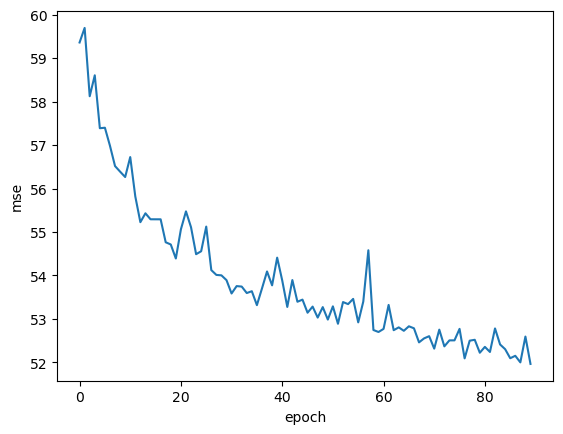

In [45]:
plt.plot(history.history["mse"][10:])
plt.gca().set(xlabel="epoch",ylabel="mse")
plt.show()

In [46]:
model.evaluate(X_test,y_test,verbose=2)

53/53 - 0s - loss: 52.5285 - mae: 5.5738 - mse: 52.5285 - 153ms/epoch - 3ms/step


[52.528533935546875, 5.573784351348877, 52.528533935546875]

In [47]:
predictions = model.predict(X_test)

53/53 [==============================] - 0s 752us/step


In [48]:
predictions,y_test

(array([[ -8.960768  ,  53.62487   ],
        [ -0.86802226,  59.85226   ],
        [-12.741067  ,  53.003082  ],
        ...,
        [-14.249142  ,  51.08859   ],
        [ 11.791884  ,  59.049423  ],
        [ 18.006348  ,  49.113358  ]], dtype=float32),
 array([[ -9.375,  55.   ],
        [ 23.5  ,  62.75 ],
        [-21.5  ,  48.5  ],
        ...,
        [-14.5  ,  59.5  ],
        [  9.5  ,  55.625],
        [ 22.375,  42.25 ]], dtype=float32))

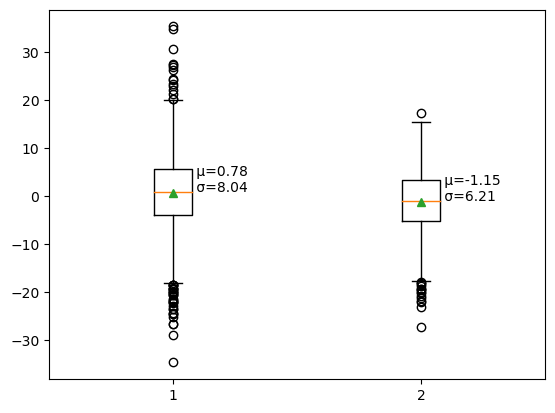

In [49]:
diff = predictions-y_test
diffmean = diff.mean(axis=0)
diffstd = diff.std(axis=0)
fig, ax = plt.subplots()
bp = ax.boxplot(diff,showmeans=True)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean[i], diffstd[i])
    ax.annotate(text, xy=(x, y))
plt.show()

In [50]:
y_test

array([[ -9.375,  55.   ],
       [ 23.5  ,  62.75 ],
       [-21.5  ,  48.5  ],
       ...,
       [-14.5  ,  59.5  ],
       [  9.5  ,  55.625],
       [ 22.375,  42.25 ]], dtype=float32)

In [51]:
model1spread = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(1)
])

model1pts = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(1)
])

model1spread.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mae','mse'])
model1pts.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae','mse'])

history1spread = model1spread.fit(X_train,y_train[:,0],epochs=100,verbose=1)
history1pts = model1pts.fit(X_train,y_train[:,1],epochs=100,verbose=1)



Epoch 1/100
123/123 [==============================] - 0s 1ms/step - loss: 191.6097 - mae: 10.9547 - mse: 191.6097
Epoch 2/100
123/123 [==============================] - 0s 1ms/step - loss: 105.1343 - mae: 7.9361 - mse: 105.1343
Epoch 3/100
123/123 [==============================] - 0s 1ms/step - loss: 75.2814 - mae: 6.6337 - mse: 75.2814
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 72.7003 - mae: 6.4871 - mse: 72.7003
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 73.0258 - mae: 6.5324 - mse: 73.0258
Epoch 6/100
123/123 [==============================] - 0s 1ms/step - loss: 71.1536 - mae: 6.4219 - mse: 71.1536
Epoch 7/100
123/123 [==============================] - 0s 1ms/step - loss: 71.2928 - mae: 6.4226 - mse: 71.2928
Epoch 8/100
123/123 [==============================] - 0s 1ms/step - loss: 73.0192 - mae: 6.5011 - mse: 73.0192
Epoch 9/100
123/123 [==============================] - 0s 1ms/step - loss: 71.6091 - mae: 6.4527 - 

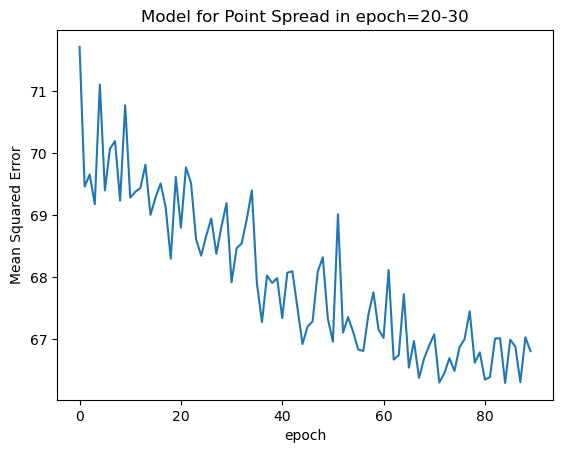

In [52]:
plt.plot(history1spread.history["mse"][10:])
plt.gca().set(xlabel="epoch",ylabel="mse")
plt.title("Model for Point Spread in epoch=20-30")
plt.ylabel("Mean Squared Error")
plt.show()

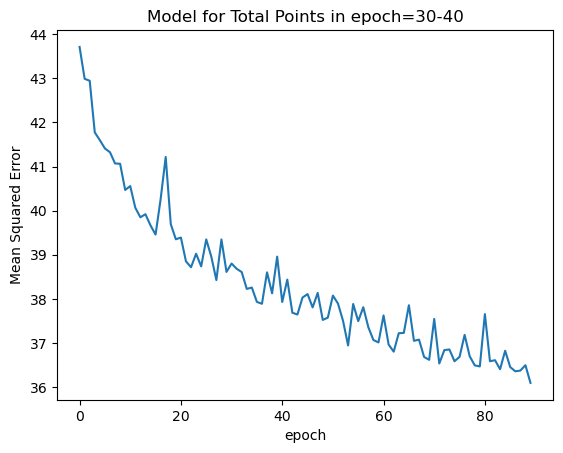

In [53]:
plt.plot(history1pts.history["mse"][10:])
plt.gca().set(xlabel="epoch",ylabel="mse")
plt.title("Model for Total Points in epoch=30-40")
plt.ylabel("Mean Squared Error")
plt.show()

In [54]:
model1spread.evaluate(X_test,y_test[:,0],verbose=2)

53/53 - 0s - loss: 65.4403 - mae: 6.1086 - mse: 65.4403 - 134ms/epoch - 3ms/step


[65.44026947021484, 6.108635902404785, 65.44026947021484]

In [55]:
model1pts.evaluate(X_test,y_test[:,1],verbose=1)

53/53 [==============================] - 0s 873us/step - loss: 39.1253 - mae: 4.9536 - mse: 39.1253


[39.12532424926758, 4.953632831573486, 39.12532424926758]

In [56]:
predictions1spread = model1spread.predict(X_test)
predictions1pts = model1pts.predict(X_test)

53/53 [==============================] - 0s 827us/step


In [93]:
predictions1spread,y_test[:,0]

(array([[-11.50298  ],
        [ -2.4866939],
        [-14.993827 ],
        ...,
        [-16.259077 ],
        [  9.336207 ],
        [ 15.350257 ]], dtype=float32),
 array([ -9.375,  23.5  , -21.5  , ..., -14.5  ,   9.5  ,  22.375],
       dtype=float32))

In [94]:
predictions1spread.shape, y_test[:,0].shape

((1677, 1), (1677,))

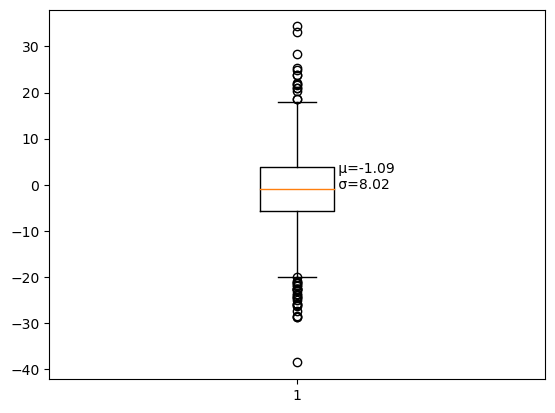

In [109]:
diff = predictions1spread.flatten() - y_test[:,0]
diffmean = diff.mean()
diffstd = diff.std()
fig, ax = plt.subplots()
bp = ax.boxplot(diff)
for i, line in enumerate(bp['medians']):
    _x, _y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean, diffstd)
    plt.annotate(text, xy=(_x,_y))
plt.show()

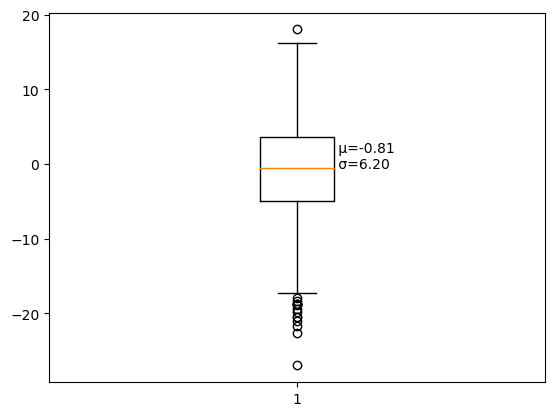

In [110]:
diff = predictions1pts.flatten() - y_test[:,1]
diffmean = diff.mean()
diffstd = diff.std()
fig, ax = plt.subplots()
bp = ax.boxplot(diff)
for i, line in enumerate(bp['medians']):
    _x, _y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean, diffstd)
    plt.annotate(text, xy=(_x,_y))
plt.show()

WORKING WITH AWAY AND HOME PTS

In [60]:
predict_scores_df=df_merged[['away_points', 'home_points']] #predictions using scores not betting lines

In [61]:
y_scores=np.array(predict_scores_df,dtype=np.float32)  #use y_scores as y in model

In [62]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y_scores,test_size=0.2)  #haven't run model yet
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.125)

#note: I don't see the need for validation dataset, we have a small sample size

In [63]:
model2 = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train2.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(2)
])

In [64]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               5400      
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 2)                 202       
                                                                 
Total params: 15,702
Trainable params: 15,702
Non-trainable params: 0
_________________________________________________________________


In [65]:
model2.compile(optimizer='adam',
              loss='mse',
              metrics=['mae','mse'])

In [66]:
history = model2.fit(X_train2,y_train2,epochs=100,verbose=1)

Epoch 1/100
123/123 [==============================] - 0s 1ms/step - loss: 346.6844 - mae: 14.6542 - mse: 346.6844
Epoch 2/100
123/123 [==============================] - 0s 1ms/step - loss: 188.2206 - mae: 11.0938 - mse: 188.2206
Epoch 3/100
123/123 [==============================] - 0s 1ms/step - loss: 185.8012 - mae: 11.0222 - mse: 185.8012
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 179.6993 - mae: 10.8307 - mse: 179.6993
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 167.3939 - mae: 10.4476 - mse: 167.3939
Epoch 6/100
123/123 [==============================] - 0s 1ms/step - loss: 147.7361 - mae: 9.7858 - mse: 147.7361
Epoch 7/100
123/123 [==============================] - 0s 1ms/step - loss: 133.6945 - mae: 9.2921 - mse: 133.6945
Epoch 8/100
123/123 [==============================] - 0s 1ms/step - loss: 130.5955 - mae: 9.1514 - mse: 130.5955
Epoch 9/100
123/123 [==============================] - 0s 1ms/step - loss: 129.1361

In [67]:
model2.evaluate(X_test2,y_test2,verbose=2)

35/35 - 0s - loss: 126.0645 - mae: 8.9115 - mse: 126.0645 - 164ms/epoch - 5ms/step


[126.06451416015625, 8.911459922790527, 126.06451416015625]

In [68]:
score_predictions=model2.predict(X_test2)

35/35 [==============================] - 0s 795us/step


In [69]:
score_predictions, y_test2

(array([[22.472967, 21.81351 ],
        [20.584082, 32.85054 ],
        [27.342865, 42.690735],
        ...,
        [36.849854, 22.882652],
        [27.120346, 23.937468],
        [18.407661, 25.787214]], dtype=float32),
 array([[24., 17.],
        [30., 31.],
        [37., 34.],
        ...,
        [49., 10.],
        [24.,  6.],
        [34., 27.]], dtype=float32))

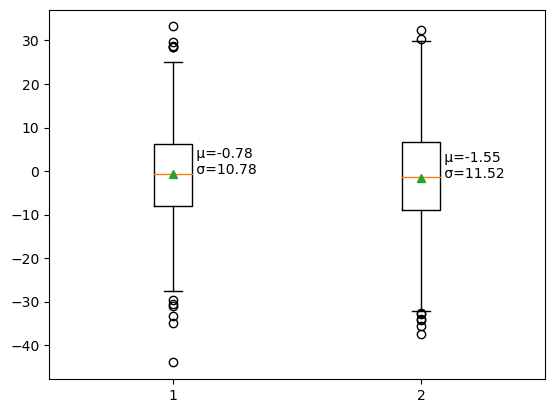

In [70]:
diff = score_predictions-y_test2
diffmean = diff.mean(axis=0)
diffstd = diff.std(axis=0)
fig, ax = plt.subplots()
bp = ax.boxplot(diff,showmeans=True)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean[i], diffstd[i])
    ax.annotate(text, xy=(x, y))
plt.show()

In [71]:
game_output=pd.DataFrame(score_predictions)
game_output=game_output.rename(columns={0:'Predicted Away Score', 1:'Predicted Home Score'})
game_output['Away Score']=predict_scores_df['away_points']
game_output['Home Score']=predict_scores_df['home_points']
game_output['Away Difference']=game_output['Predicted Away Score']-game_output['Away Score']
game_output['Home Difference']=game_output['Predicted Home Score']-game_output['Home Score']
game_output

,Predicted Away Score,Predicted Home Score,Away Score,Home Score,Away Difference,Home Difference
0,22.472967,21.813511,13,17,9.472967,4.813511
1,20.584082,32.850540,15,14,5.584082,18.850540
2,27.342865,42.690735,24,13,3.342865,29.690735
3,20.832819,31.095772,14,12,6.832819,19.095772
4,27.987696,21.870588,17,24,10.987696,-2.129412
...,...,...,...,...,...,...
1113,12.087697,41.470539,22,19,-9.912303,22.470539
1114,20.532911,20.952890,21,24,-0.467089,-3.047110
1115,36.849854,22.882652,17,59,19.849854,-36.117348
1116,27.120346,23.937468,21,38,6.120346,-14.062532


In [72]:
away_sd=np.std(game_output['Away Difference'])
home_sd=np.std(game_output['Home Difference'])

game_output['Adjusted Away Score']=np.rint(np.random.normal(game_output['Predicted Away Score'],away_sd))
game_output['Adjusted Home Score']=np.rint(np.random.normal(game_output['Predicted Home Score'],home_sd))

In [73]:
game_output

,Predicted Away Score,Predicted Home Score,Away Score,Home Score,Away Difference,Home Difference,Adjusted Away Score,Adjusted Home Score
0,22.472967,21.813511,13,17,9.472967,4.813511,-3.0,18.0
1,20.584082,32.850540,15,14,5.584082,18.850540,26.0,5.0
2,27.342865,42.690735,24,13,3.342865,29.690735,59.0,44.0
3,20.832819,31.095772,14,12,6.832819,19.095772,4.0,34.0
4,27.987696,21.870588,17,24,10.987696,-2.129412,31.0,32.0
...,...,...,...,...,...,...,...,...
1113,12.087697,41.470539,22,19,-9.912303,22.470539,-7.0,70.0
1114,20.532911,20.952890,21,24,-0.467089,-3.047110,-18.0,39.0
1115,36.849854,22.882652,17,59,19.849854,-36.117348,26.0,59.0
1116,27.120346,23.937468,21,38,6.120346,-14.062532,29.0,9.0


In [74]:
#working with game spread and game avg
predict_actual_line_df = df_merged[["game_spread","game_totalpts"]]

In [75]:
X = np.array(parameters_df,dtype=np.float32)
y_actual_lines = np.array(predict_actual_line_df,dtype=np.float32)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X,y_actual_lines,test_size=0.2)

In [76]:
model3 = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train3.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(2)
])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               5400      
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 2)                 202       
                                                                 
Total params: 15,702
Trainable params: 15,702
Non-trainable params: 0
_________________________________________________________________


In [77]:
model3.compile(optimizer='adam',
               loss='mse',
               metrics=['mae','mse'])

history = model3.fit(X_train3,y_train3,epochs=100,verbose=1)

Epoch 1/100
140/140 [==============================] - 0s 1ms/step - loss: 699.6887 - mae: 20.1545 - mse: 699.6887
Epoch 2/100
140/140 [==============================] - 0s 1ms/step - loss: 379.6559 - mae: 15.2493 - mse: 379.6559
Epoch 3/100
140/140 [==============================] - 0s 1ms/step - loss: 373.2030 - mae: 15.1288 - mse: 373.2030
Epoch 4/100
140/140 [==============================] - 0s 1ms/step - loss: 356.4627 - mae: 14.7898 - mse: 356.4627
Epoch 5/100
140/140 [==============================] - 0s 1ms/step - loss: 324.6618 - mae: 14.1538 - mse: 324.6618
Epoch 6/100
140/140 [==============================] - 0s 1ms/step - loss: 287.9215 - mae: 13.3221 - mse: 287.9215
Epoch 7/100
140/140 [==============================] - 0s 1ms/step - loss: 267.6863 - mae: 12.8639 - mse: 267.6863
Epoch 8/100
140/140 [==============================] - 0s 1ms/step - loss: 262.2946 - mae: 12.7568 - mse: 262.2946
Epoch 9/100
140/140 [==============================] - 0s 1ms/step - loss: 259.1

In [78]:
model3.evaluate(X_test3,y_test3,verbose=2)

35/35 - 0s - loss: 252.6237 - mae: 12.7441 - mse: 252.6237 - 168ms/epoch - 5ms/step


[252.62368774414062, 12.74411392211914, 252.62368774414062]

In [79]:
actual_lines_predictions=model3.predict(X_test3)

35/35 [==============================] - 0s 1ms/step


In [80]:
actual_lines_predictions, y_test3

(array([[ 1.5894338 , 64.937     ],
        [11.078008  , 58.10827   ],
        [15.94558   , 63.123367  ],
        ...,
        [22.549171  , 58.538414  ],
        [ 0.47601798, 48.554455  ],
        [ 9.05532   , 75.21913   ]], dtype=float32),
 array([[ -1.,  57.],
        [  3.,  45.],
        [ 14.,  42.],
        ...,
        [ 33.,  65.],
        [-15.,  55.],
        [  3.,  59.]], dtype=float32))

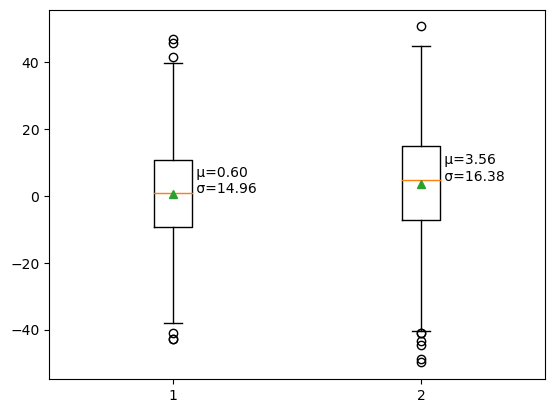

In [81]:
diff = actual_lines_predictions-y_test3
diffmean = diff.mean(axis=0)
diffstd = diff.std(axis=0)
fig, ax = plt.subplots()
bp = ax.boxplot(diff,showmeans=True)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean[i], diffstd[i])
    ax.annotate(text, xy=(x, y))
plt.show()

## Creating Alternative Pairing System

In [82]:
api_instance3 = cfbd.TeamsApi(cfbd.ApiClient(configuration))

In [83]:
team_locations=DataFunctions.get_team_locations(api_instance3,conferences)

In [84]:
team_locations

,team,id,latitude,longitude
0,Air Force,2005,38.996970,-104.843616
1,Akron,2006,41.072553,-81.508341
2,Alabama,333,33.208275,-87.550384
3,Appalachian State,2026,36.211427,-81.685428
4,Arizona,12,32.228805,-110.948868
...,...,...,...,...
128,Western Kentucky,98,36.984790,-86.459404
129,Western Michigan,2711,42.286006,-85.600757
130,West Virginia,277,39.650274,-79.955187
131,Wisconsin,275,43.069940,-89.412694
